In [152]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [153]:
img = "azjintiubk"
test_bgr_img = cv2.imread(f"./data/train/{img}.jpeg")

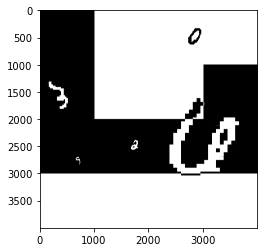

In [154]:
# matplotlib interprets images in RGB format, but OpenCV uses BGR format
# so to convert the image so that it's properly loaded, convert it before loading
rgb_img = cv2.cvtColor(test_bgr_img, cv2.COLOR_BGR2RGB)	
plt.imshow(rgb_img)

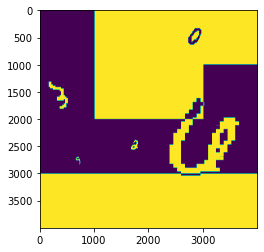

In [155]:
gray_img = cv2.cvtColor(test_bgr_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img)

In [156]:
def get_pixel_count(img):
    img1d = img.reshape(-1)
    pixels, counts = np.unique(img1d, return_counts=True)
    return {str(pixel): count for pixel, count in zip(pixels, counts)}

pixel_count = get_pixel_count(gray_img)
print(pixel_count)

{'0': 6523083, '1': 4382, '2': 959, '3': 404, '4': 164, '5': 48, '6': 8, '7': 10, '248': 4, '249': 7, '250': 59, '251': 193, '252': 468, '253': 1061, '254': 4903, '255': 9464247}


In [157]:
# convert all pixels greater than 0 to 1
binary_img = cv2.threshold(gray_img, 1, 1, cv2.THRESH_BINARY)[1]
pixel_count = get_pixel_count(binary_img)
print(f"binary_img.shape = {binary_img.shape}")
print(f"binary image pixel count = {pixel_count}")

binary_img.shape = (4000, 4000)
binary image pixel count = {'0': 6527465, '1': 9472535}


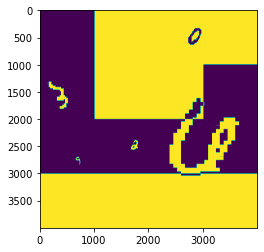

In [158]:
plt.imshow(binary_img)

In [159]:
def count_0_and_1(img):   
    count_0, count_1 = 0, 0 
    for row in range(img.shape[0]):        
        for col in range(img.shape[1]):
            if img[row][col] == 1:
                count_1 += 1
            elif img[row][col] == 0:                
                count_0 += 1
    return count_0, count_1

def invert_pixels(img):    
    count_0, count_1 = count_0_and_1(img)
    # If the image is predominantly white, invert the pixels
    if count_0 < count_1:        
        for row in range(img.shape[0]):        
            for col in range(img.shape[1]):
                if img[row][col] == 1:
                    img[row][col] = 0
                elif img[row][col] == 0:                
                    img[row][col] = 1
    return img    

In [160]:
def invert_pixels_fast(img):
    img1d = img.reshape(-1)
    pixels, counts = np.unique(img1d, return_counts=True)
    pixel_count = {str(pixel): count for pixel, count in zip(pixels, counts)}
    if "1" in pixel_count:
        invert_pixel = lambda x: 0 if x == 1 else 1
        v_invert_pixel = np.vectorize(invert_pixel)
        # if only white pixels or majority pixels are white
        if "0" not in pixel_count or pixel_count["0"] < pixel_count["1"]:
            # perform vectorized pixel inversion on 1d numpy array
            img_transformed = v_invert_pixel(img1d)
            img = img_transformed.reshape(1000, 1000)    
    return img

In [161]:
# split the 4000 * 4000 binary_image into 16 tiles of 1000 * 1000 and tranform each tile to have a black background
# with white digits
def split_and_transform_img(img):    
    img_tiles = []
    for x in range(4):
        x_start = x * 1000
        x_end = x_start + 1000
        row_img_list = []
        for y in range(4):
            y_start = y * 1000
            y_end = y_start + 1000            
            row_img_list.append(invert_pixels_fast(img[x_start:x_end, y_start:y_end]))
        img_tiles.append(row_img_list)
    return np.array(img_tiles)

In [162]:
# join the transformed tiled images to reconstruct 4000 * 4000 binary image
def join_tiles(tfmd_img_tiles):    
    row_tiles = []
    for i in range(4):
        # join 4 tiles to create a row tile
        row_tiles.append(np.concatenate(tfmd_img_tiles[i, :], axis=1))
    return np.concatenate(row_tiles, axis=0)

In [163]:
img_tiles = split_and_transform_img(binary_img)

In [164]:
tfmd_binary_img = join_tiles(img_tiles)
tfmd_binary_img.shape

(4000, 4000)

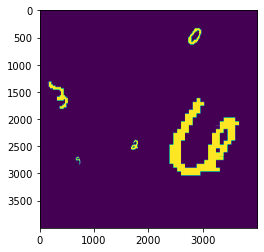

In [165]:
plt.imshow(tfmd_binary_img)

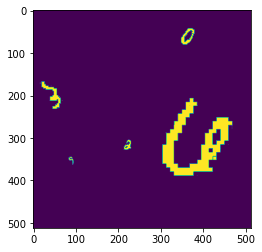

In [192]:
# opencv resize function only works with numpy arrays of float types
tfmd_bin_img_resized = cv2.resize(tfmd_binary_img.astype('float32'), (512, 512), interpolation=cv2.INTER_LINEAR)
plt.imshow(tfmd_bin_img_resized)

In [193]:
tfmd_bin_img_resized.shape

(512, 512)

In [166]:
# convert the 4000 * 4000 * 3 image to grayscale
# apply thresholding to convert pixel values to 0 or 1
# split the 4000 * 4000 image into tiles of 1000 * 1000 each
# apply pixel inversion on each tile to have black background and white digit
# stich together the transformed tiles to get transformed grayscale image
# apply bounding boxes on the white blobs to identify and extract digits

# apply the above algorithm on one image first

In [167]:
blob_detector = cv2.SimpleBlobDetector_create()
detected_blobs = blob_detector.detect(test_bgr_img)
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(test_bgr_img, detected_blobs, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#plt.imshow(cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2RGB))

In [168]:
blob_detector

<SimpleBlobDetector 0x7f8014557410>